# Visualisation of epidemiological data from Minion sequencing data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import folium
from ipykernel import kernelapp as app
import IPython.display as display
%matplotlib inline
pd.options.display.mpl_style = 'default'

/Users/mbhall88/Dropbox/Programs/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


## Displaying a map in folium

First we just want to get a map displayed, preferably of Queensland.

In [3]:
# Folium defaults to OpenStreetMap tiles, but Stamen Terrain, Stamen Toner, 
# Mapbox Bright, and Mapbox Control room tiles are built in
map_1 = folium.Map(location=[-27.46499, 153.02661366666666], zoom_start=12,
                  tiles='OpenStreetMap')
display.display(map_1)

In [4]:
# import a table of postcode -> latitude and longitude for map display 
pc_df = pd.read_csv("Australian_Post_Codes_Lat_Lon.csv")
pc_df.head()

,postcode,suburb,state,dc,type,lat,lon
0,200,AUSTRALIAN NATIONAL UNIVERSITY,ACT,AUSTRALIAN NATIONAL UNI LPO,Post Office Boxes,-35.277272,149.117136
1,221,BARTON,ACT,NaN,LVR,-35.201372,149.095065
2,800,DARWIN,NT,DARWIN DELIVERY CENTRE,Delivery Area,-12.801028,130.955789
3,801,DARWIN,NT,DARWIN DELIVERY CENTRE,Post Office Boxes,-12.801028,130.955789
4,804,PARAP,NT,PARAP,Post Office Boxes,-12.432181,130.843310


In [8]:
# now, let's import the data
df = pd.read_csv("Outbreak.csv", index_col="Submission_ID")
df = df[np.isfinite(df['Postcode'])] # make sure the postcodes exist...
df['Postcode'] = df['Postcode'].apply(lambda x: int(x)) # and are integers
print df.columns.tolist()

['Date', 'Hospital_ID', 'Doctor_ID', 'Gender', 'Age group', 'Postcode', 'Resides in Australia', 'If no, where', 'Travel within the last 6 months? where? When', 'Patient condition', 'Allergies AB', 'Current AB', 'Date of sample collection - time stamp', 'Sample type', 'Species', 'Strain type', 'Aminocoumarin', 'Aminoglycoside', 'Beta_lactamase', 'Beta_lactamase_class_A', 'Beta_lactamase_class_B', 'Beta_lactamase_class_C', 'Beta_lactamase_class_D', 'Bleomycin', 'Chloramphenicol', 'Cycloserine', 'Aminoglycoside_daptomycin', 'Elfamycin', 'Ethambutol', 'Fluoroquinolone', 'Fosfomycin', 'FusidicAcid', 'Lincosamide', 'Macrolide', 'Penicillin', 'Polymyxin', 'Rifampin', 'Rifamycin', 'Streptothricin', 'Sulfonamide', 'Tetracycline', 'Trimethoprim', 'Tunicamycin', 'Aminoglycoside_vancomycin', 'Viomycin']


In [9]:
def get_lat_lon(pc_df, postcode, suburb = None):
    """Return average latitutde and longitude for given postcode"""
    # todo #
    # get lon/lat using address lookup (googlemaps API?)
    
    if suburb is not None:
        pc = pc_df[(pc_df['suburb'] == suburb)  & (pc_df['postcode'] == postcode)]
    else:
        pc = pc_df[pc_df['postcode'] == postcode]
    lat = pc['lat'].tolist()
    lon = pc['lon'].tolist()
    return (np.mean(lat), np.mean(lon))


Now, let's finally display the data!

In [112]:
# get map with initial view
map_1 = folium.Map(location=[-27.46499, 153.02661366666666], zoom_start=9,
                  tiles='Stamen terrain')

add_cluster_markers(df, map_1)
map_1.save('brisbane.html')
display(map_1)

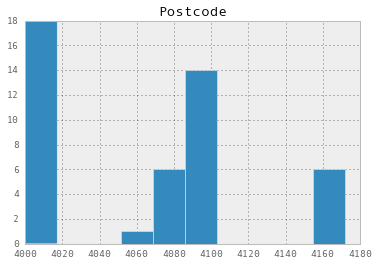

In [26]:
df.hist(column="Postcode");

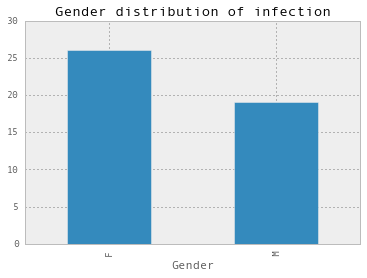

In [27]:
df['Gender'].groupby([df['Gender']]).count().plot(kind='bar', 
                                                  legend=False, 
                                                  title="Gender distribution of infection");

In [45]:
import datetime
dates = df['Date of sample collection - time stamp']

In [47]:
dates = sorted(dates, key=lambda x: datetime.datetime.strptime(x, '%d/%m/%Y'))

In [85]:
dates_list = [datetime.datetime.strptime(date, '%d/%m/%Y').date() for date in dates]

In [89]:
(dates_list[7]-dates_list[0]).days

3

In [134]:
from ipywidgets import VBox, jsdlink, IntSlider, widgets
min_date = (max(dates_list) - max(dates_list)).days
max_date = (max(dates_list) - min(dates_list)).days
s1 = IntSlider(description='Days ago', min=min_date, max=max_date, value=min_date)

In [135]:
def time_map(x):
    d = max(dates_list) - datetime.timedelta(days=x)
    d = str(d).split("-")[::-1]
    d = "/".join(d)
    build_map(df, pc_df, d)

In [137]:
widgets.interact(time_map, x=s1)

In [138]:
def build_map(df, pc_df, x):
    map_1 = folium.Map(location=[-27.46499, 153.02661366666666], zoom_start=9,
                  tiles='Stamen terrain')
    df = df[df['Date of sample collection - time stamp'] == x]
    add_cluster_markers(df, map_1)
    #map_1.save('brisbane.html')
    display(map_1)

In [114]:
def add_cluster_markers(df, map_):
    """add a marker for every record in the data, use a clustered view"""
    # todo #
    # have marker options (colour, size, etc.) as dict with default values passed to function
    
    marker_cluster = folium.MarkerCluster("Hospital cluster").add_to(map_) # cluster group
    
    for index, row in df.iterrows():
        # retrieve latitude and longitude using postcode
        lat, lon = get_lat_lon(pc_df, row['Postcode'], None) # pass suburb as third argument if possible
        # marker formatting is most easily done by passing the function html code
        html="<h3>%s, %s</h3><br>%s" %(row['Species'], row['Strain type'], 
                                             row['Date of sample collection - time stamp'])
        iframe = folium.element.IFrame(html=html, width=300, height=200) # used to display html
        popup = folium.Popup(iframe, max_width=2000)
        folium.CircleMarker(
            location = (lat, lon),
            radius=200, 
            color='#FF0000', # colour marker by strain/resitance(Y/N)
            fill_color='#FF0000',
            popup=popup
            ).add_to(marker_cluster)